In [ ]:
# Cell 1
import os
import sys
import torch
import torch.nn.functional as F
import numpy as np
from pathlib import Path

# 프로젝트 루트 경로 추가 (Jupyter 안전)
try:
    PROJECT_ROOT = Path(__file__).resolve().parents[1]
except NameError:
    PROJECT_ROOT = Path.cwd()
    # notebooks/에서 열렸다면 상위로 이동하여 `src` 탐색
    if not (PROJECT_ROOT / 'src').exists():
        if (PROJECT_ROOT.parent / 'src').exists():
            PROJECT_ROOT = PROJECT_ROOT.parent
        elif (PROJECT_ROOT.parent.parent / 'src').exists():
            PROJECT_ROOT = PROJECT_ROOT.parent.parent
sys.path.insert(0, str(PROJECT_ROOT))
print('PROJECT_ROOT =', PROJECT_ROOT)
# 작업 디렉토리를 프로젝트 루트로 강제 설정 (경로 혼동 방지)
import os as _os
try:
    _os.chdir(str(PROJECT_ROOT))
    print('CWD =', Path.cwd())
except Exception as _e:
    print('chdir failed:', _e)

from src.continual_trainer import ContinualTrainer
from src.data_loader import create_domain_dataloaders
from src.utils import normalize_signal, create_windowed_signal
from configs.model_config import DATA_CONFIG

# 공통 유틸
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('DEVICE =', DEVICE)

def get_latest_results_dir():
    """results/ 폴더에서 가장 최신 실험 폴더 자동 감지"""
    results_path = PROJECT_ROOT / 'results'
    if not results_path.exists():
        return None
    
    # 날짜시간 형식 폴더만 필터링 (YYYYMMDD_HHMMSS)
    exp_dirs = [d for d in results_path.iterdir() if d.is_dir() and len(d.name) == 15]
    
    if not exp_dirs:
        return None
    
    # 이름 기준 정렬 (최신이 마지막)
    exp_dirs.sort()
    latest = exp_dirs[-1]
    
    print(f"📁 최신 실험 폴더 자동 감지: {latest.name}")
    return f"results/{latest.name}"

def load_trainer(dataset_type: str, results_dir: str, scenario_name: str, checkpoint_name: str):
    """
    Trainer 생성 및 체크포인트 로드
    
    Args:
        dataset_type: 'uos' 
        results_dir: 결과 디렉토리 (예: 'results/20251013_133656')
        scenario_name: 시나리오 이름 (예: 'UOS_Scenario1_VaryingSpeed')
        checkpoint_name: 체크포인트 파일명 (예: 'domain_800_best.pth')
    """
    results_dir_abs = str((PROJECT_ROOT / results_dir).resolve()) if not os.path.isabs(results_dir) else results_dir
    ckpt_path = os.path.join(results_dir_abs, 'checkpoints', scenario_name, checkpoint_name)
    
    data_dir_abs = str((PROJECT_ROOT / 'data_scenario1').resolve())
    
    # Trainer 생성 (UOS만 지원) - save_dir을 None으로 설정하여 체크포인트 저장 방지
    trainer = ContinualTrainer(
        device=DEVICE,
        save_dir=None,  # 체크포인트 저장하지 않음
        domain_order=[600,800,1000,1200,1400,1600],
        data_dir=data_dir_abs,
        dataset_type=dataset_type
    )
    
    # 🎯 체크포인트 로드
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path, map_location=DEVICE)
        trainer.model.load_state_dict(checkpoint['model_state_dict'])
        trainer.model.eval()
        print(f"✅ 체크포인트 로드 성공: {ckpt_path}")
    else:
        print(f"⚠️  체크포인트 없음: {ckpt_path}")
        print(f"   랜덤 초기화 모델 사용 (정확도 낮을 것)")
    
    print(f"Checkpoint path: {ckpt_path}")
    print(f"Data dir: {data_dir_abs}")
    return trainer, ckpt_path




PROJECT_ROOT = /data/home/kyj2024/TextVibCLIP
CWD = /data/home/kyj2024/TextVibCLIP


/data/home/kyj2024/anaconda3/envs/TVCLIP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/home/kyj2024/anaconda3/envs/TVCLIP/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/data/home/kyj2024/anaconda3/envs/TVCLIP

DEVICE = cuda


In [ ]:
# Cell 2 - 통합 시각화 함수
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# UOS 7-클래스 색상 팔레트
COLORS7 = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2']

def visualize_retrieval(results_dir: str,
                        sample_number: int,
                        domain_rpm: int = 600,
                        subset: str = 'test',
                        scenario: str = 'UOS_Scenario1_VaryingSpeed',
                        save_path: str = None):
    """
    UOS 실험 결과에서 특정 샘플의 cosine similarity 시각화 (통합 함수)
    
    Args:
        results_dir: 실험 결과 디렉토리 (예: 'results/20251016_155531')
        sample_number: 시각화할 샘플 번호 (0부터 시작)
        domain_rpm: 도메인 RPM (600, 800, 1000, 1200, 1400, 1600)
        subset: 데이터 서브셋 ('test' 또는 'val')
        scenario: 시나리오 이름
        save_path: 저장 경로 (옵션)
    """
    print(f"🔍 UOS Cosine Similarity Visualization")
    print(f"   Results dir: {results_dir}")
    print(f"   Sample number: {sample_number}")
    print(f"   Domain: {domain_rpm}RPM")
    print(f"   Subset: {subset}")
    print(f"   Scenario: {scenario}")
    print()
    
    # 체크포인트 파일명 결정
    if domain_rpm == 600:
        checkpoint = 'first_domain_final.pth'
    else:
        checkpoint = f'domain_{domain_rpm}_best.pth'
    
    # Trainer 로드
    trainer, ckpt_path = load_trainer('uos', results_dir, scenario, checkpoint)
    
    # 도메인별 dataloader 준비
    loaders = create_domain_dataloaders(
        data_dir='data_scenario1', 
        domain_order=[600,800,1000,1200,1400,1600], 
        dataset_type='uos', 
        batch_size=64
    )
    loader = loaders[domain_rpm][subset]
    
    # 샘플 선택
    dataset = loader.dataset
    print(f"📁 Dataset: UOS {domain_rpm}RPM ({subset}) - {len(dataset)} samples")
    
    if sample_number >= len(dataset):
        print(f"⚠️  Sample number {sample_number} is out of range [0, {len(dataset)-1}]")
        sample_number = sample_number % len(dataset)
        print(f"   Adjusted to: {sample_number}")
    
    sample = dataset[sample_number]
    
    vib = sample['vibration'].unsqueeze(0).to(DEVICE)
    labels_uos = sample['labels'].unsqueeze(0)  # [1,2] 구조
    
    # UOS 7-클래스 텍스트 프롬프트
    prompt_bank = {
        0: ["healthy bearing"],          # H_H
        1: ["bearing with ball fault"],  # H_B
        2: ["inner race fault"],         # H_IR
        3: ["outer race fault"],         # H_OR
        4: ["mechanical looseness"],     # L_H
        5: ["rotor unbalance"],          # U_H
        6: ["shaft misalignment"],       # M_H
    }
    
    # 텍스트 프로토타입 생성 및 추론
    trainer.model.eval()
    with torch.no_grad():
        # 진동 신호 임베딩
        vib_raw = trainer.model.vib_encoder(vib)
        vib_emb = F.normalize(trainer.model.vib_projection(vib_raw), p=2, dim=1)
        
        # 텍스트 프로토타입 임베딩
        proto = []
        for cls_id in [0,1,2,3,4,5,6]:
            raw = trainer.model.text_encoder.encode_texts(prompt_bank[cls_id], DEVICE)
            proj = F.normalize(trainer.model.text_projection(raw), p=2, dim=1)
            proto.append(F.normalize(proj.mean(dim=0, keepdim=True), p=2, dim=1))
        proto_mat = torch.cat(proto, dim=0)
        
        # Cosine similarity 계산
        sims = vib_emb @ proto_mat.t()
        pred = sims.argmax(dim=1).item()
    
    # 클래스 이름
    prompts7 = [
        "Healthy bearing", "Ball fault", "Inner race fault", "Outer race fault",
        "Mechanical looseness", "Rotor unbalance", "Shaft misalignment"
    ]
    
    # Ground truth 라벨 추출
    try:
        gt_idx = int(labels_uos[0, 0].item())
        gt_text = prompts7[gt_idx] if 0 <= gt_idx < len(prompts7) else None
    except Exception:
        gt_text = None
    
    print(f"🎯 Prediction: {prompts7[pred]} (label {pred})")
    if gt_text:
        print(f"🏷️  Ground Truth: {gt_text} (label {gt_idx})")
        print(f"✅ Correct: {'Yes' if pred == gt_idx else 'No'}")
    print()
    
    # 시각화
    _plot_retrieval_result(
        vib_signal=vib,
        prompts=prompts7,
        sims=sims,
        pred_idx=pred,
        title=f"UOS {domain_rpm}RPM ({subset})",
        true_label=gt_text,
        sample_index=sample_number,
        save_path=save_path
    )

def _plot_retrieval_result(vib_signal: torch.Tensor,
                          prompts: list,
                          sims: torch.Tensor,
                          pred_idx: int,
                          title: str = 'Retrieval Result',
                          true_label: str = None,
                          sample_index: int = None,
                          save_path: str = None):
    """
    내부 시각화 함수 (실제 플롯 생성) - 논문용 개선 버전
    """
    vib_np = vib_signal.detach().cpu().numpy().reshape(-1)
    sims_np = sims.detach().cpu().numpy().reshape(-1)

    num_classes = len(prompts)
    colors = COLORS7[:num_classes]

    # 논문용 figure 크기 조정
    fig = plt.figure(figsize=(14, 5.2))
    gs = fig.add_gridspec(1, 2, width_ratios=[0.8, 1.7], 
                         hspace=0.3, wspace=0.3)

    # Left: Vibration signal
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.plot(vib_np, color='#34495e', linewidth=1.2)
    ax0.set_title('Vibration Signal', fontweight='bold', fontsize=12)
    ax0.set_xlabel('Samples', fontsize=10)
    ax0.set_ylabel('Amplitude', fontsize=10)
    ax0.tick_params(labelsize=9)

    # Right: Cosine similarity bars
    ax1 = fig.add_subplot(gs[0, 1])
    x = np.arange(num_classes)
    bars = ax1.bar(x, sims_np, color=colors, alpha=0.8, edgecolor='white', linewidth=1.0)
    
    # 예측된 클래스 강조 (논문용 스타일)
    bars[pred_idx].set_edgecolor('#d62728')
    bars[pred_idx].set_linewidth(2.5)
    
    # y=0 기준선 추가 (음수 값 시각화 개선)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.7)

    # X tick labels 처리 (음수 값 겹침 방지)
    ax1.set_xticks(x)
    
    # 라벨 텍스트 처리 및 위치 조정
    label_texts = []
    for p in prompts:
        # 긴 라벨은 줄임
        if len(p) > 15:
            label_texts.append(p[:12] + '...')
        else:
            label_texts.append(p)
    
    ax1.set_xticklabels(label_texts, rotation=25, ha='right', fontsize=9)
    
    # 음수 값이 있을 때 x tick labels 위치 조정
    min_val = float(sims_np.min()) if sims_np.size > 0 else 0
    if min_val < 0:
        # 음수 값이 있으면 x축 아래쪽에 여백 추가
        margin = abs(min_val) * 0.3
        ax1.set_ylim(min_val - margin, None)
        
        # x tick labels를 더 아래로 이동
        ax1.tick_params(axis='x', pad=15)
        
        # x축 라벨 위치 조정
        for tick in ax1.get_xticklabels():
            tick.set_y(tick.get_position()[1] - 0.02)
    
    ax1.set_title('Cosine Similarity (Text Prototypes)', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Similarity', fontsize=10)
    ax1.tick_params(labelsize=9)
    
    # 그리드 추가 (논문용)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_axisbelow(True)

    # 동적 y-limit 설정 (음수 고려)
    maxy = float(sims_np.max()) if sims_np.size > 0 else 1.0
    miny = float(sims_np.min()) if sims_np.size > 0 else 0.0
    
    if miny >= 0:
        # 양수만 있는 경우
        ylim_top = max(maxy * 1.25, maxy + 0.02)
        ylim_top = max(0.2, ylim_top)
        ax1.set_ylim(0, ylim_top)
    else:
        # 음수가 있는 경우
        ylim_top = max(maxy * 1.15, maxy + 0.05)
        ylim_bottom = min(miny * 1.15, miny - 0.05)
        ax1.set_ylim(ylim_bottom, ylim_top)

    # 각 bar 위/아래에 similarity 값 표시 (음수 고려)
    ylim_bottom, ylim_top = ax1.get_ylim()
    y_range = ylim_top - ylim_bottom
    
    for i, (b, val) in enumerate(zip(bars, sims_np)):
        if val >= 0:
            # 양수: bar 위에 표시
            text_y = b.get_height() + y_range * 0.02
            va = 'bottom'
        else:
            # 음수: bar 아래에 표시
            text_y = b.get_height() - y_range * 0.02
            va = 'top'
        
        ax1.text(b.get_x() + b.get_width()/2, text_y, 
                f"{val:.3f}", ha='center', va=va, fontsize=8,
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

    # 제목 구성 (논문용 간결한 스타일)
    if true_label is not None and sample_index is not None:
        title_line = f"{title} | GT: {true_label} | Pred: {prompts[pred_idx]} | Sample #{sample_index}"
    elif true_label is not None:
        title_line = f"{title} | GT: {true_label} | Pred: {prompts[pred_idx]}"
    elif sample_index is not None:
        title_line = f"{title} | Pred: {prompts[pred_idx]} | Sample #{sample_index}"
    else:
        title_line = f"{title} | Pred: {prompts[pred_idx]}"

    fig.suptitle(title_line, fontsize=13, fontweight='bold', y=0.95)
    
    # 레이아웃 최적화
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
    plt.show()

def test_negative_values_visualization():
    """
    음수 값이 있는 bar plot 시각화 테스트 함수
    """
    print("🧪 음수 값이 있는 Bar Plot 시각화 테스트")
    
    # 테스트 데이터 (일부 음수 값 포함)
    prompts = ["Healthy", "Ball fault", "Inner race", "Outer race", "Looseness", "Unbalance", "Misalignment"]
    sims_np = np.array([0.85, -0.12, 0.23, 0.67, -0.34, 0.91, -0.08])  # 일부 음수 포함
    pred_idx = 5  # "Unbalance"가 최고값
    
    # 가상의 진동 신호
    vib_signal = torch.randn(1, 1024)
    
    print(f"   Similarity values: {sims_np}")
    print(f"   Prediction: {prompts[pred_idx]} (index {pred_idx})")
    print()
    
    # 시각화 함수 호출
    _plot_retrieval_result(
        vib_signal=vib_signal,
        prompts=prompts,
        sims=torch.tensor(sims_np),
        pred_idx=pred_idx,
        title="Negative Values Test",
        true_label="Unbalance",
        sample_index=999
    )

print("✅ 통합 시각화 함수 로드 완료")
print("✅ 음수 값 테스트 함수 로드 완료")



✅ 통합 시각화 함수 로드 완료


In [3]:
# Cell 3 - 사용법 예제
print("📖 UOS Cosine Similarity Visualization 사용법")
print("=" * 60)
print()
print("🔧 기본 사용법:")
print("visualize_retrieval(")
print("    results_dir='results/20251016_155531',")
print("    sample_number=100,")
print("    domain_rpm=600,")
print("    subset='test'")
print(")")
print()
print("🎯 매개변수 설명:")
print("   - results_dir: 실험 결과 폴더 경로")
print("   - sample_number: 시각화할 샘플 번호 (0부터 시작)")
print("   - domain_rpm: 도메인 RPM (600, 800, 1000, 1200, 1400, 1600)")
print("   - subset: 'test' 또는 'val'")
print("   - scenario: 시나리오 이름 (기본값: 'UOS_Scenario1_VaryingSpeed')")
print("   - save_path: 저장 경로 (옵션)")
print()
print("💡 팁:")
print("   - 여러 도메인을 비교하려면 새로운 셀에서 domain_rpm만 변경")
print("   - 다른 실험 결과를 보려면 results_dir 변경")
print("   - 샘플 번호를 바꿔가며 다양한 결과 확인")
print()

📖 UOS Cosine Similarity Visualization 사용법

🔧 기본 사용법:
visualize_retrieval(
    results_dir='results/20251016_155531',
    sample_number=100,
    domain_rpm=600,
    subset='test'
)

🎯 매개변수 설명:
   - results_dir: 실험 결과 폴더 경로
   - sample_number: 시각화할 샘플 번호 (0부터 시작)
   - domain_rpm: 도메인 RPM (600, 800, 1000, 1200, 1400, 1600)
   - subset: 'test' 또는 'val'
   - scenario: 시나리오 이름 (기본값: 'UOS_Scenario1_VaryingSpeed')
   - save_path: 저장 경로 (옵션)

💡 팁:
   - 여러 도메인을 비교하려면 새로운 셀에서 domain_rpm만 변경
   - 다른 실험 결과를 보려면 results_dir 변경
   - 샘플 번호를 바꿔가며 다양한 결과 확인



🔍 UOS Cosine Similarity Visualization
   Results dir: results/20251016_155531
   Sample number: 100
   Domain: 600RPM
   Subset: test
   Scenario: UOS_Scenario1_VaryingSpeed

✅ 체크포인트 로드 성공: /data/home/kyj2024/TextVibCLIP/results/20251016_155531/checkpoints/UOS_Scenario1_VaryingSpeed/first_domain_final.pth
Checkpoint path: /data/home/kyj2024/TextVibCLIP/results/20251016_155531/checkpoints/UOS_Scenario1_VaryingSpeed/first_domain_final.pth
Data dir: /data/home/kyj2024/TextVibCLIP/data_scenario1
📁 Dataset: UOS 600RPM (test) - 1169 samples
🎯 Prediction: Rotor unbalance (label 5)
🏷️  Ground Truth: Rotor unbalance (label 5)
✅ Correct: Yes



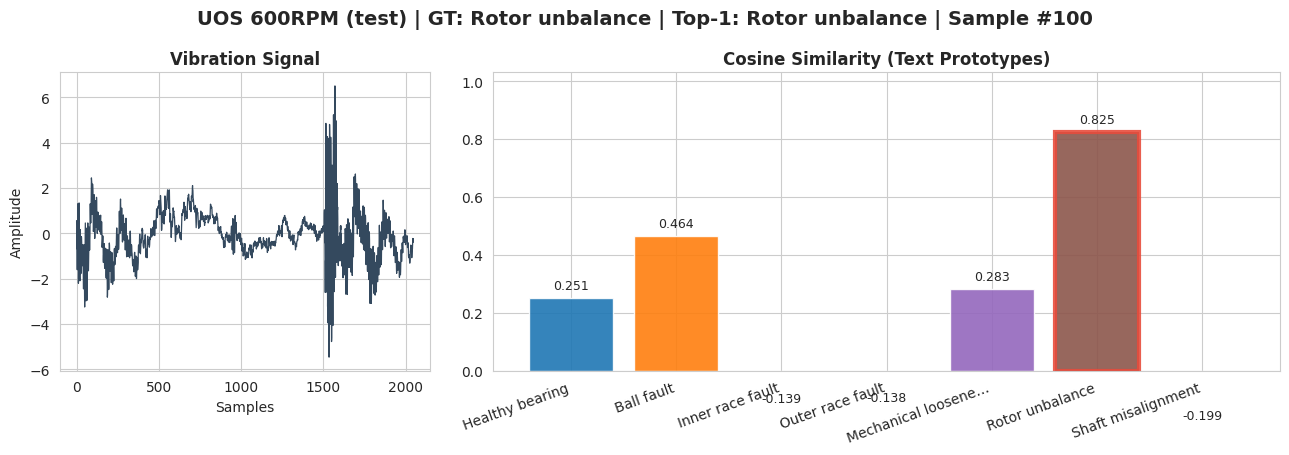

In [4]:
# Cell 4 - 예제 1: 기본 시각화
visualize_retrieval(
    results_dir='results/20251016_155531',
    sample_number=100,
    domain_rpm=600,
    subset='test'
)


🔍 UOS Cosine Similarity Visualization
   Results dir: results/20251016_155531
   Sample number: 100
   Domain: 800RPM
   Subset: test
   Scenario: UOS_Scenario1_VaryingSpeed

✅ 체크포인트 로드 성공: /data/home/kyj2024/TextVibCLIP/results/20251016_155531/checkpoints/UOS_Scenario1_VaryingSpeed/domain_800_best.pth
Checkpoint path: /data/home/kyj2024/TextVibCLIP/results/20251016_155531/checkpoints/UOS_Scenario1_VaryingSpeed/domain_800_best.pth
Data dir: /data/home/kyj2024/TextVibCLIP/data_scenario1
📁 Dataset: UOS 800RPM (test) - 1169 samples
🎯 Prediction: Rotor unbalance (label 5)
🏷️  Ground Truth: Rotor unbalance (label 5)
✅ Correct: Yes



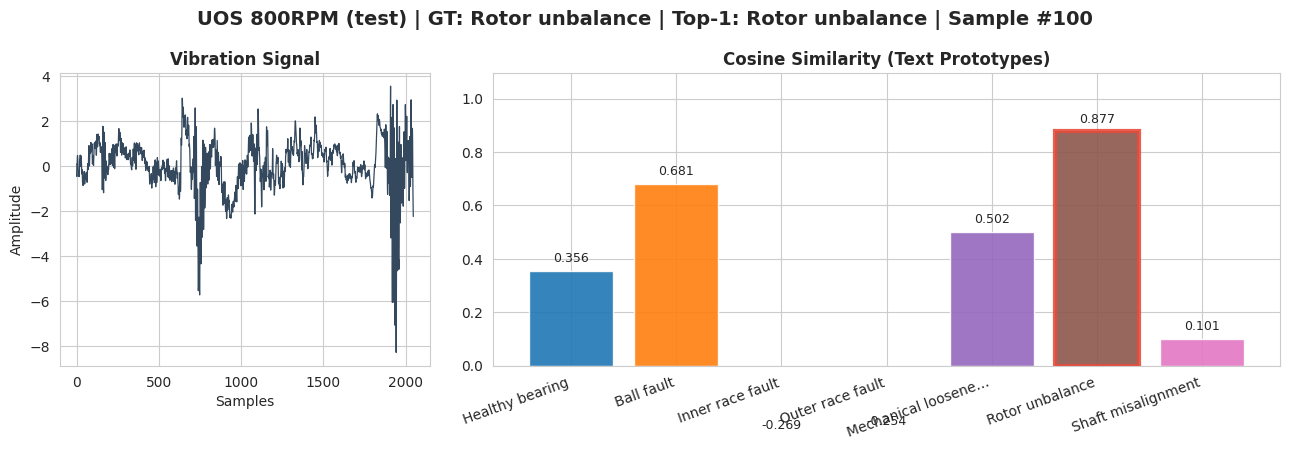

In [5]:
# Cell 5 - 예제 2: 다른 도메인 (800RPM)
visualize_retrieval(
    results_dir='results/20251016_155531',
    sample_number=100,
    domain_rpm=800,
    subset='test'
)


🔍 UOS Cosine Similarity Visualization
   Results dir: results/20251016_155531
   Sample number: 500
   Domain: 600RPM
   Subset: test
   Scenario: UOS_Scenario1_VaryingSpeed

✅ 체크포인트 로드 성공: /data/home/kyj2024/TextVibCLIP/results/20251016_155531/checkpoints/UOS_Scenario1_VaryingSpeed/first_domain_final.pth
Checkpoint path: /data/home/kyj2024/TextVibCLIP/results/20251016_155531/checkpoints/UOS_Scenario1_VaryingSpeed/first_domain_final.pth
Data dir: /data/home/kyj2024/TextVibCLIP/data_scenario1
📁 Dataset: UOS 600RPM (test) - 1169 samples
🎯 Prediction: Mechanical looseness (label 4)
🏷️  Ground Truth: Mechanical looseness (label 4)
✅ Correct: Yes



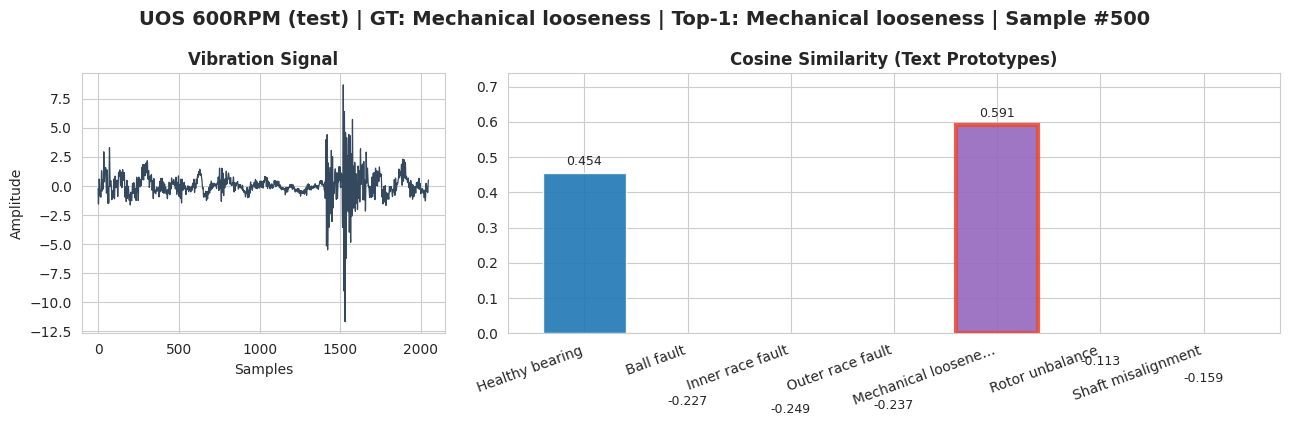

In [6]:
# Cell 6 - 예제 3: 다른 샘플 번호
visualize_retrieval(
    results_dir='results/20251016_155531',
    sample_number=500,
    domain_rpm=600,
    subset='test'
)


## 📝 사용법 가이드

### 🔧 기본 사용법
```python
visualize_retrieval(
    results_dir='results/20251016_155531',
    sample_number=100,
    domain_rpm=600,
    subset='test'
)
```

### 🎯 매개변수 설명
- **`results_dir`**: 실험 결과 폴더 경로 (예: `'results/20251016_155531'`)
- **`sample_number`**: 시각화할 샘플 번호 (0부터 시작)
- **`domain_rpm`**: 도메인 RPM (600, 800, 1000, 1200, 1400, 1600)
- **`subset`**: 데이터 서브셋 (`'test'` 또는 `'val'`)
- **`scenario`**: 시나리오 이름 (기본값: `'UOS_Scenario1_VaryingSpeed'`)
- **`save_path`**: 저장 경로 (옵션, 예: `'my_plot.png'`)

### 💡 실험 팁
1. **도메인 비교**: 같은 샘플로 다른 도메인(RPM) 비교
2. **샘플 다양성**: 같은 도메인에서 다른 샘플들 확인
3. **실험 비교**: 다른 실험 결과와 성능 비교
4. **저장 기능**: 좋은 결과는 `save_path`로 저장

### 🔍 결과 해석
- **왼쪽**: 원본 진동 신호
- **오른쪽**: 7개 클래스에 대한 cosine similarity
- **빨간 테두리**: 모델이 예측한 클래스
- **숫자**: 각 클래스의 similarity 점수


In [ ]:
# Cell 8 - 음수 값 테스트 (논문용 개선된 시각화)
test_negative_values_visualization()


## 🔧 음수 값 Bar Plot 개선사항

### 📊 논문용 시각화 개선
1. **음수 값 겹침 해결**: 
   - 음수 값이 있을 때 x축 아래쪽에 여백 추가
   - x tick labels 위치를 아래로 이동하여 겹침 방지
   - `tick_params(axis='x', pad=15)`로 라벨 간격 확보

2. **시각적 개선**:
   - y=0 기준선 추가로 양수/음수 구분 명확화
   - 음수 값은 bar 아래에, 양수 값은 bar 위에 텍스트 표시
   - 텍스트에 흰색 배경 박스 추가로 가독성 향상

3. **논문용 스타일링**:
   - 고해상도 (300 DPI) 저장 지원
   - 그리드 추가로 값 읽기 편의성 향상
   - 폰트 크기 및 색상 조정으로 전문적인 외관
   - 간결한 제목 형식

### 🎯 주요 해결 방법
- **동적 y-limit**: 음수 값 범위에 맞춰 자동 조정
- **스마트 텍스트 배치**: 양수/음수에 따른 텍스트 위치 자동 결정
- **여백 관리**: `plt.subplots_adjust()`로 레이아웃 최적화
- **라벨 처리**: 긴 클래스명 자동 축약 및 회전 각도 조정
